In [104]:
%load_ext autoreload
% autoreload 2
from __future__ import print_function
import argparse
import os, datetime
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
print(torch.__version__)
from geant_dataloader import rtnpy_load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from torch.autograd import grad
#from logistics import sigmoid_normalize, logistic_unnormalize, tanh_normalize, arctanh_unnormalize
from logistics import *
from matplotlib import gridspec
plt.rc('font', family='serif')
from decimal import Decimal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4.0a0+200fb22


In [105]:
workers = 2
batchSize = 32
imageSize =32
nz = 100
ngf = 64
ndf = 64
nc = 1
niter = 50
lr = 2e-4
beta1 = 0.5
cuda = 'store_true'
netG = "output/"
netD = "output/"
outf = "output/"
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
epoch=0 #will be updated during the run
extraD = 1
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []

mean_energy_f = []
mean_energy_r = []


norm_scale = 'unif'

try:
    os.makedirs(outf)
except OSError:
    pass



In [106]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Random Seed:  25
Using Cuda
cuda:2
Using: gpu 0


In [107]:
# LOAD DATA:

#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", num_events = 100, image_size = imageSize)
image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/geant4Data_30000Events_"+str(imageSize)+"ImageSize_800MeV_ScintiAbsoThickness75_8.npz", num_events = 100, image_size = imageSize)


In [108]:
#plt.hist(image_array[0][0][:,0])
# for i in range(image_array.shape[0]):
#     if np.isnan(image_array[i][0]).any():
#         del image_array[i][0]
#print(image_array[~np.isnan(image_array).any(axis=0)])
#print(image_array)
#image_array = np.delete(image_array, 10840, axis = 0)
normed_array, scale = normalize(image_array, norm_scale = norm_scale )
#normed_array, scale = sigmoid_normalize(image_array)
print(image_array.shape)
tensor_array = torch.stack([torch.tensor(i, requires_grad =False).type(torch.FloatTensor) for i in normed_array])
tensor_data = torch.utils.data.TensorDataset(tensor_array)
dataloader = torch.utils.data.DataLoader(tensor_data, batch_size=batchSize, num_workers=2)
dataloader

(30000, 1, 32, 32)


In [114]:
if norm_scale == 'unif':
    last_layer = nn.LeakyReLU(0.01) #nn.Sigmoid()
elif norm_scale == 'none' or norm_scale =='0to5':
    #last_layer = nn.LeakyReLU(0.02)
    last_layer = nn.ReLU()
else:
    last_layer = nn.Tanh()


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            #nn.Tanh()
            last_layer
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

class Generator32(nn.Module):
    def __init__(self, ngpu):
        super(Generator32, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #inc, outc, kernel, stride, padding, output padding
#             nn.ConvTranspose2d(     nz, 32 * 8, 2, 1, 0, bias=False),
#             nn.BatchNorm2d(32 * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 2 x 2
#             nn.ConvTranspose2d(32 * 8, 32 * 4, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 4 x 4
#             nn.ConvTranspose2d(32 * 4, 32 * 2, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 8 x 8
#             nn.ConvTranspose2d(32 * 2,     32, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             # state size. (ngf) x 16 x 16
#             nn.ConvTranspose2d(    32,      nc, 2, 2, 0, bias=False),
#             last_layer
#             # state size. (nc) x 64 x 64
            
            nn.ConvTranspose2d(     nz, 32 * 8, 2, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 2 x 2
            nn.ConvTranspose2d(32 * 8, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(32 * 4, 32 * 2, 5, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(32 * 2,     32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(    32,      nc, 4, 2, 0, bias=False),
            last_layer
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output
    
    
if imageSize == 32:
    netG = Generator32(ngpu).to(device)
else:
    netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # kernel size = 4 (so I image 4 x 4 x 1)
            # stride = 2, 
            # padding = 1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
           # nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)
    
class Discriminator32(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator32, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            # kernel size = 4 (so kernel filter 4 x 4 x 1)
            # stride = 2, 
            # padding = 0
#             nn.Conv2d(nc, 32, 2, 2, 0, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 16 x 16
#             nn.Conv2d(32, 32 * 2, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 8 x 8
#             nn.Conv2d(32 * 2, 32 * 4, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 4 x 4
#             nn.Conv2d(32 * 4, 32 * 8, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 2 x 2
#             nn.Conv2d(32 * 8, 1, 2, 2, 0, bias=False),
#             nn.Sigmoid()
            nn.Conv2d(nc, ndf, 5, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.ReLU( inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 3, 2, 0, bias=False)
           # nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

if imageSize == 32:
    netD = Discriminator32(ngpu).to(device)
else:
    netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if opt.netD != '':
#    netD.load_state_dict(torch.load(opt.netD))
print(netD)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
#print(netG)

Generator32(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (13): LeakyReLU(negative_slope=0.01)
  )
)
Discriminator32(
  (main): Se

In [115]:
def make_samples(netG, n_events=500, real=True, fake = True, scale = scale, norm_scale = norm_scale ):

    #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
    fake_image = 0 #arctanh_unnormalize(test_image, scale)
    real_image = 0
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake_output = netG(noise)
        gen_image = fake_output.to('cpu').detach().numpy()[0][0]
        fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
        #fake_image += logistic_unnormalize(test_image, scale)
    fake_image = fake_image / n_events
    real_image = real_image / n_events

    #test_noNans = np.copy(test_unnormed)
    #test_unnormed[test_unnormed < 0.0] = np.nan
    if real == True and fake == True:
        return [real_image,fake_image], n_events
    elif (real == False) and (fake == True):
        return fake_image, n_events
    else:
        return real_image, n_events
    
    
    

def make_stacked_samples(netG, n_events, real=False, fake=True, norm_scale = norm_scale, scale = scale):
    fake_images = []
    real_images = []
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image = image_array[idx][0]
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake_output = netG(noise)
        fake_image = fake_output.to('cpu').detach().numpy()[0][0]
        fake_image = unnormalize(fake_image,scale, norm_scale=norm_scale)
        fake_images.append(fake_image)
        real_images.append(real_image)
        
    fake_images_array = np.dstack(fake_images).T
    real_images_array = np.dstack(real_images).T
    if real == True and fake == True:
        return real_images_array,fake_images_array
    elif (real == False) and (fake == True):
        return fake_images_array
    else:
        return real_images_array


def plot_avg(data, n_events, withMarginals=True, save_dir = mydir, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale=norm_scale):

    test_noNans = np.copy(data)
    test_unnormed = data
    test_unnormed[test_unnormed < 0.0] = np.nan
    
    fig=plt.figure(figsize=(6, 6))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.935, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.935, gamma=2.5, hue=1).as_hex()
    
    if withMarginals == False:
        plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        if save_dir != None:
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
            filename = "DCWGAN_AvgEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epochs" + str(epoch) + "_" + str(batchSize) + "batchSize_" +  str(lr) + "lr.pdf"
            plt.savefig(directory + filename)
        
    else:
        marginals_str = 'withMarginals'
        img=test_noNans
        t = np.arange(-50,50, 100/float(imageSize))
        #t = np.arange(img.shape[0])
        f = np.arange(-50,50, 100/float(imageSize))
        #f = np.arange(img.shape[1])
        flim = (f.min(), f.max())
        tlim = (t.min(), t.max())

        gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
        gs.update(hspace=0, wspace=0)

        ax = fig.add_subplot(gs[1,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent = extent, origin = 'lower', cmap = cmap)
        ax.text(-45, 39, 'DCWGAN', color='black', 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
        cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
        ax.yaxis.set_ticks_position('right')
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        ax.spines["top"].set_visible(False)
        ax.spines['left'].set_visible(False)

        axl = fig.add_subplot(gs[1,0], sharey=ax)
        axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
        axl.invert_xaxis()
        axb = fig.add_subplot(gs[0,1], sharex=ax)
        axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

        plt.setp(axl.get_yticklabels(), visible=False)
        plt.setp(axb.get_xticklabels(), visible=False)
        plt.setp(axl.get_xticklabels(), visible=False)
        plt.setp(axb.get_yticklabels(), visible=False)

        axl.yaxis.set_ticks_position('none')
        axb.xaxis.set_ticks_position('none')
        axl.xaxis.set_ticks_position('none')
        axb.yaxis.set_ticks_position('none')


        axl.spines["top"].set_visible(False)
        axl.spines['right'].set_visible(False)
        axl.spines['left'].set_visible(False)
        axl.spines['bottom'].set_visible(False)
        axb.spines["top"].set_visible(False)
        axb.spines["right"].set_visible(False)
        axb.spines["left"].set_visible(False)
        axb.spines["bottom"].set_visible(False)
        ax.set_xlim(tlim)
        ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
        ax.xaxis.set_label_coords(0.02,-0.05)
        ax.set_ylim(tlim)
        ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
        ax.yaxis.set_label_coords(1.07,0.98)
        if save_dir != None:
            learning_rate = '%.0E' % Decimal(lr)
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
            filename = "DCWGAN_AvgEdep"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
            plt.savefig(save_dir + filename, bbox_inches='tight')
        plt.show()
    return

def plot_samples(n_samples = 3, scale = scale, norm_scale = norm_scale ):
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    vmin = 0.1
    vmax = 2.0
    fig, ax_arr = plt.subplots(1, n_samples, figsize=(10,10), sharey = True, sharex=True)
    i = 0
    for ax in ax_arr.flatten():
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  unnormalize(test_image, scale = scale, norm_scale =norm_scale)
        test_unnormed[test_unnormed < 0.01] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        if i == 0:   
            cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        i+=1
    plt.show()
    return

def plot_sns(n_events = 500, n_samples = 3, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale, scale = scale):
    
    fig, axn = plt.subplots(1, n_samples, figsize=(12,4), sharex=True, sharey=True)
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #xticks = [-50,-25,0,25,50]
    #yticks = [-50,-25,0,25,50]
    for i, ax in enumerate(axn.flat):
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake = netG(noise)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if i != 0:
            ax.spines['left'].set_visible(False)
        if i == 0:
            ax.set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
            ax.set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
        ax.set_title("Ex " +str(i), x =0.85, y = 0.88, alpha=0.6, fontweight='heavy', fontsize=11)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  unnormalize(test_image, scale = scale, norm_scale = norm_scale)
        #test_unnormed = logistic_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
        #sns.heatmap(test_unnormed, ax=ax, cmap=cmap,
        #            cbar=i == 0, cbar_ax=None if i else cbar_ax, square=True,
        #            vmin = 0, vmax = 80, xticklabels = xticks, yticklabels=xticks)
        im = ax.imshow(test_unnormed, vmin = 0, vmax=10, extent=extent, origin='lower', cmap=cmap)
        ax.tick_params(axis=u'both', which=u'both',length=0)

    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    fig.colorbar(im, cax=cbar_ax)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle("Samples of Generated Electron Gun Energy Depositions",x=0.5,y=0.99)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCWGAN_3SampleEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_avg_both(real_data, fake_data, n_events, withMarginals=True, save_dir=None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale, scale = scale):
    fig=plt.figure(figsize=(10,5))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #real_data = real_image
    img = real_data
    test_unnormed = fake_data
    test_noNans = np.copy(test_unnormed)
    img2 = test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())


    gs = gridspec.GridSpec(2, 4, width_ratios=[5,1,1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)
    ax1 = fig.add_subplot(gs[1,0])
    axl = fig.add_subplot(gs[1,1], sharey=ax1)
    axb = fig.add_subplot(gs[0,0], sharex=ax1)
    ax2 = fig.add_subplot(gs[1,3])
    axl2= fig.add_subplot(gs[1,2], sharey=ax2)
    axb2= fig.add_subplot(gs[0,3], sharex=ax2)
    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)
    plt.setp(axl2.get_yticklabels(), visible=False)
    plt.setp(axb2.get_xticklabels(), visible=False)
    plt.setp(axl2.get_xticklabels(), visible=False)
    plt.setp(axb2.get_yticklabels(), visible=False)
    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')
    axl2.yaxis.set_ticks_position('none')
    axb2.xaxis.set_ticks_position('none')
    axl2.xaxis.set_ticks_position('none')
    axb2.yaxis.set_ticks_position('none')
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    im = ax1.imshow(real_data, vmin = 0, extent =extent, origin='lower', cmap=cmap)
    ax1.spines["top"].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.915, gamma=2.5, hue=1).as_hex()
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax1.set_xlim(tlim)
    
    ax1.set_ylim(tlim)


    #RECONSIDER TAKING OUT THE LESS THAN 0 VALUES
    real_data[real_data < 0.0] = np.nan 


    test_unnormed[test_unnormed < 0.0] = np.nan

    im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
    ax2.spines["top"].set_visible(False)
    ax2.spines['left'].set_visible(False)
    axl2.fill_between(img2.mean(1), f, alpha = 0.7, color = color_list[1])
    axl2.invert_xaxis()
    axl2.spines["top"].set_visible(False)
    axl2.spines['right'].set_visible(False)
    axl2.spines['left'].set_visible(False)
    axl2.spines['bottom'].set_visible(False)
    axb2.fill_between(t, img2.mean(0), alpha =0.7, color= color_list[1])
    axb2.spines["top"].set_visible(False)
    axb2.spines["right"].set_visible(False)
    axb2.spines["left"].set_visible(False)
    axb2.spines["bottom"].set_visible(False)
    ax2.set_xlim(tlim)
    ax2.set_ylim(tlim)

    ax1.set_xlabel("Real", fontsize=12)  
    ax2.set_xlabel("Generator", fontsize=12)
    ax1.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax1.yaxis.set_label_coords(-0.07,0.98)
    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    plt.figtext(0.05,0.060,r"$\mathit{x}$", fontsize = 12)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle(r" DCWGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
                 + str(imageSize) + "x" +str(imageSize) + " \n Image Size", x = 0.46, y = 0.02)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCWGAN_RealandFakeAvgEdep"+str(withMarginals) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale, scale = scale):
    
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if rows <= 2 and columns <=4:
        scale_factor = 3.5
    else:
        scale_factor = 2
    
    fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
    #print(len(axes))
    event_number = 0
    plt.locator_params(axis='y', nbins=1)
    plt.locator_params(axis='x', nbins=2)
    #fig.xticks(rotation=45)
    for i in range(rows):
        for j in range(columns):

            #print(range(rows))
            image_array = data[event_number]

            image_array[image_array < 0.0000] = np.nan
            #cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
            cmap = plt.cm.copper_r
            image_array = np.ma.masked_where(image_array < 0.004, image_array)
            cmap.set_bad(color='white')
            
            #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
            #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
            #cmap = sns.color_palette("BrBG",7)
            #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
            #axes[i,j].set_aspect('equal')
            plt.axis('on')
            if rows == 1:
                #axes[j] = plt.subplot(gs1[i,j])
                if j != 0:
                    axes[j].spines['left'].set_visible(False)
                else:
                    axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                axes[j].spines['top'].set_visible(False)
                axes[j].spines['right'].set_visible(False)
                #axes[j].spines['bottom'].set_visible(False)
                #axes[j].spines['left'].set_visible(False)
                #axes[j].set_aspect('equal')
                im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[j].set_xticklabels([])
                axes[j].set_yticklabels([])
                axes[j].xaxis.set_ticks_position('none')
                axes[j].yaxis.set_ticks_position('none')
                event_number +=1
            else:
                #axes[i,j].spines['top'].set_visible(False)
                axes[i,j].spines['bottom'].set_visible(True)
                if j!= 0:
                    axes[i,j].spines['left'].set_visible(False)
                if i == range(rows)[-1] and j == 0:
                    axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
                if j == range(columns)[-1]:
                    axes[i,j].spines['right'].set_visible(True)
                else:
                    axes[i,j].spines['right'].set_visible(False)
                im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[i,j].set_xticklabels([])
                axes[i,j].set_yticklabels([])
                axes[i,j].xaxis.set_ticks_position('none')
                axes[i,j].yaxis.set_ticks_position('none')
                event_number +=1
    #fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
   # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
    #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=-0.085, hspace=0.00)
    if real == True:
        fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions, " + str(imageSize) + "x" + str(imageSize) , y = 0.95)
    else:
        fig.suptitle("DCWGAN Samples of Generator Electron Gun Energy Depositions, " + str(imageSize) + "x" + str(imageSize) , y=0.95)
    
    num_samples = rows *columns
        
        
    if save_dir != None:
        if real == True:
            type_string = "real"
        else:
            type_string = "fake"
        
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCWGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        #print(save_dir)
        plt.savefig(save_dir + filename, bbox_inches='tight')
        
    plt.show()
    return



def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if imageSize == 64:
        vmin = -4
        vmax = 4
    elif imageSize == 32:
        vmin = -10
        vmax = 10
    
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = vmin,vmax = vmax, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'DCWGAN', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCWGAN_EdepDifferenceOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.pdf"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return



def plot_FWHMs(gen_FWHMs, real_FWHMs, epochs = epochs, n_epochs=niter,  bs=batchSize, extraD=extraD, norm_scale=norm_scale, save_dir = None):



    print(type(bs))
    FWHM_comp =  "FWHMComp_Egun_Edep_DCWGAN_" + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" +  \
                str(extraD) + "ExtraD " + str(norm_scale) +  "normalized.pdf"
    fig = plt.figure(figsize=(6,4))
    plt.scatter(epochs, real_FWHMs, alpha = 0.8, label='Geant4')
    plt.scatter(epochs, gen_FWHMs, alpha = 0.8,  label='generator')
    plt.xlabel("Epoch", fontsize = 12.5)
    plt.ylabel("FWHM", fontsize = 12.5)
    #plt.ylim(0,50)
    plt.xlim(0,n_epochs)
    plt.title(r" FWHM  for $E_{dep}$ diff, $N_{D}$ =" +  str(extraD) + " Batch Size " + str(bs) + " Input Norm " + str(norm_scale), fontsize=11)
    plt.legend(loc='best')
    if save_dir != None:
        
        plt.savefig(save_dir + FWHM_comp)
    plt.show()

    return 

def hist_width(hist_data):

    mean = hist_data.mean()
    std = hist_data.std()
    FWHM = 2.*np.sqrt(2.*np.log(2.))*std
    #line2 = FWHM - (FHWM / 2)
    #line1 = line2 - FWHM

    return FWHM

def plot_all_metrics(gen_FWHMs, g4_FWHMs, gen_means, g4_means, epochs, bs=batchSize, n_epochs =niter, extraD = extraD, norm_scale=norm_scale, save_dir =None):

#     if gamma == 0.1:
#         gamma_val = str('01')
#     elif gamma == 0.5:
#         gamma_val = str('05')
#     elif gamma == 1.0:
#         gamma_val = str('1')

    #gen_means = np.array(gen_means)
    #gen_means = gen_means
    #gen_kurts = gen_means[:,1]
    #g4 = np.array(g4_means)
    #g4_means = g4_means
    #g4_kurts = g4_means[:,1]

    #if Kurts == True:
    #    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), sharey = False, sharex = True)

    #else:

    #print(type(gen_FWHMs), type)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), sharey = False, sharex = True)

    ax1.scatter(epochs, g4_FWHMs, alpha = 0.75, label = 'geant4');
    ax1.scatter(epochs, gen_FWHMs, alpha = 0.70, label = 'generator');
    ax1.set_title("FWHMs")
    if len(epochs) < n_epochs/2:
        ax1.set_xlim(0,n_epochs /2)
    else:
        ax1.set_xlim(0,n_epochs)
    fig.suptitle(r" Distribution Metrics for $E_{dep}$, " + str(imageSize) + "x" + str(imageSize) + " DCWGAN", x=0.5, y = 1.02, fontsize = 14) 
    #plt.xlabel(r"Difference in $P_{T}$ compared to Ground Truth")
    #ax1.set_xlabel(r"$P_{T} - P_{T}^{sim} $ (MeV)", fontsize = 16)
    #ax1.set_ylabel("FWHM", fontsize = 14)
    #ax1.set_ylim(0,9000)

    ax2.scatter(epochs, g4_means, alpha = 0.75, label = 'geant4');
    ax2.scatter(epochs, gen_means, alpha = 0.70, label = 'generator');
    ax2.set_title("Means")
    if len(epochs) < n_epochs/2:
        ax2.set_xlim(0,n_epochs /2)
    else:
        ax2.set_xlim(0,n_epochs)

#     if Kurts == True:
#         ax3.scatter(epochs, delphes_kurts,alpha = 0.75, label = 'delphes');
#         ax3.scatter(epochs, gen_kurts, alpha = 0.70, label = 'generator');
#         ax3.set_title("Kurtoses")
#         ax3.set_ylim(0,5)

    fig.text(0.5, -0.01, "Epoch", ha = 'center', fontsize = 15)
    ax1.legend(loc='best')
    #if Kurts == True:
    #    ax1.legend(bbox_to_anchor=[3.94, 0.5], loc='center right')
    #else:
    ax1.legend(bbox_to_anchor=[2.64, 0.5], loc='center right')


    if save_dir != None:
        FWHMs_Means_comp =  'FHWMsMeans_Edep_EGunDCWGAN_'  \
             + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" \
              + str(extraD) + "ExtraD_" + str(norm_scale) + "Normalized.pdf"

        #file_path = "/home/chris/Documents/MPhilProjects/ForViewing/plots/eGunPTSmearing/FWHMsMeans/"
        plt.savefig(save_dir + FWHMs_Means_comp, bbox_inches="tight")

    plt.show()

    return



def xsection_multi(data_avg, epoch, savedir=mydir, imageSize =imageSize):
    fig, axes = plt.subplots(3,4, figsize=(11,8.5))
    gen = data_avg[1]
    real = data_avg[0]
    print(gen.mean(), real.mean())
    if imageSize == 64:
        xs = np.arange(0,64,1)
    else:
        xs = np.arange(0,32,1)
    l = 0
    #fig.ylim(0,15)
    for i in range(3):
        for j in range(4):
        
            if imageSize == 64:
                k = l + 26
                axes[i,j].set_ylim(0,15)
            else:
                k = l + 10
                axes[i,j].set_ylim(0,25)
            ys_gen = gen[:,k]
            ys_real = real[:,k]
            axes[i,j].plot(xs, ys_real, label = 'Geant4', alpha=0.8, linewidth=5, color ='black')
            axes[i,j].plot(xs, ys_gen, label = 'generator', alpha=0.9, linewidth = 2, linestyle='--', color='red')
            #axes[i,j].set_ylim(0,15)
            if j == 0 and i == 2:
                #axes[i,j].set_yticklabels([])
                #axes[i,j].set_xticklabels([])
                continue;
            elif j == 0 and i != 2:
                #axes[i,j].set_yticklabels([])
                axes[i,j].set_xticklabels([])
            elif i== 2:
                axes[i,j].set_yticklabels([])
                axes[i,j].set_yticks([])
            else:
                axes[i,j].set_yticklabels([])
                axes[i,j].set_xticklabels([])
                axes[i,j].set_xticks([])
                axes[i,j].set_yticks([])
            l+=1
            
    axes[0,0].legend(bbox_to_anchor=[4.8, -0.5], loc='center right', fontsize=13)
    plt.subplots_adjust(wspace=0, hspace=0)
    #plt.plot(np.arange(0,64,1),gen[:,31], label = 'VAE')
    #plt.plot(np.arange(0,64,1),real[:,31], label = 'Geant4')
    #plt.title("Cross-Section Across Middle of Distribution", fontsize=13)
    #plt.legend(x = )
    fig.suptitle(r"DCWGAN Comparing Cross-Sections Across Average $E_{dep}$ Image, " + str(imageSize) + "x" + str(imageSize), y = 0.92, fontsize =15)
    #plt.tight_layout()
    plt.savefig(mydir + "Cross-Section_Multi" + str(epoch) + ".pdf", bbox_inches='tight')
    return

In [118]:
#criterion = nn.BCELoss()
fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1 - .001
fake_label = 0 + .001
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


def gradient_penalty(x, g, lamda):
        assert x.size() == g.size()
        a = torch.rand(x.size(0), 1)
        a = a.to(device)
        a = a\
            .expand(x.size(0), x.nelement()//x.size(0))\
            .contiguous()\
            .view(
                x.size(0),
                1,
                imageSize,
                imageSize
            )
        interpolated = (a*x.data + (1-a)*g.data).to(device)
        print("INTER:" + str(interpolated.shape))
        interpolated.requires_grad_()
        c = netD(interpolated)
        gradients = grad(
            c, interpolated, grad_outputs=(
                torch.ones(c.size()).to(device)
            ),
            create_graph=True,
            retain_graph=True,
        )[0]
        return lamda * ((1-(gradients+1e-16).norm(2, dim=1))**2).mean()

    
#gradient_penalty(real_cpu, fake, lamda = 1.0)   

/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCWGAN/2018-08-28_07-30-58/


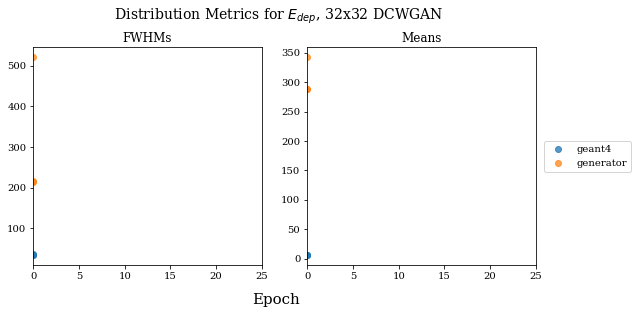

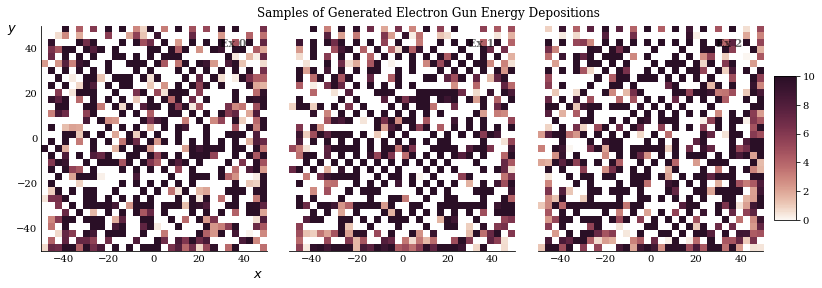

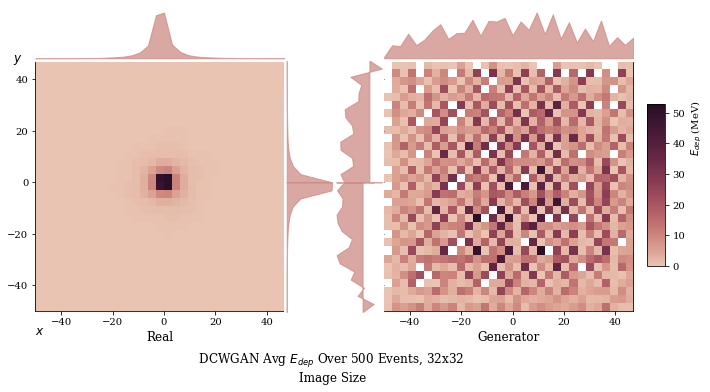

/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


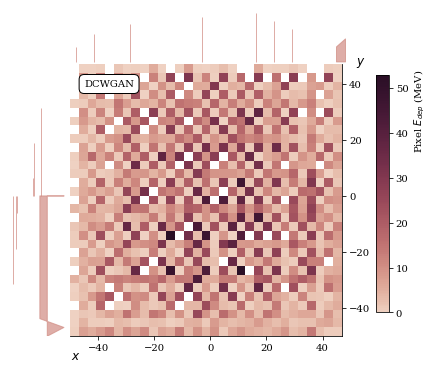

/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:344: RuntimeWarning: invalid value encountered in less


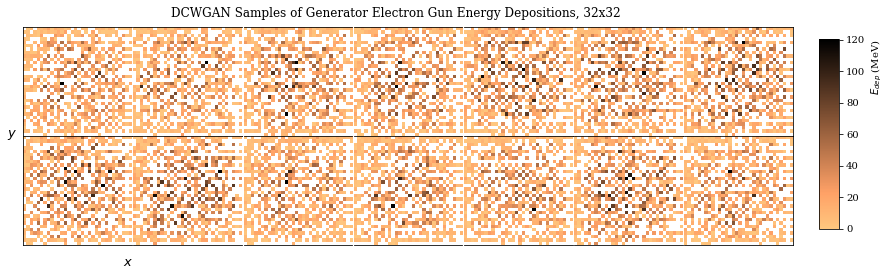

nan 0.19981942071571157


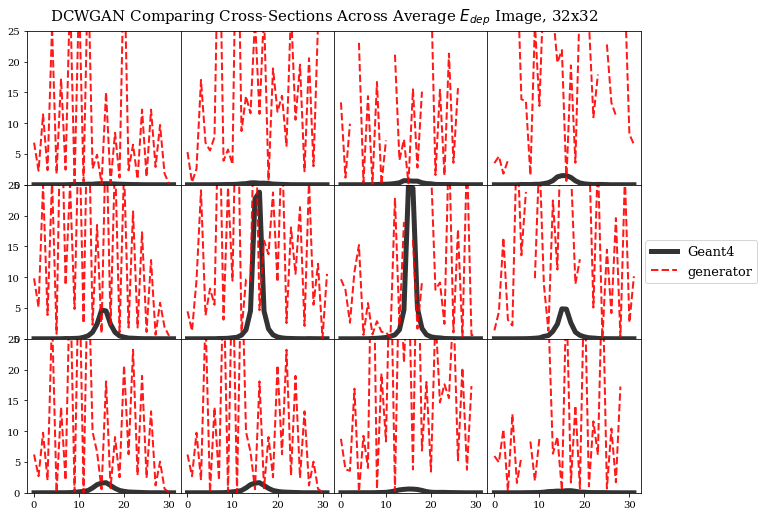

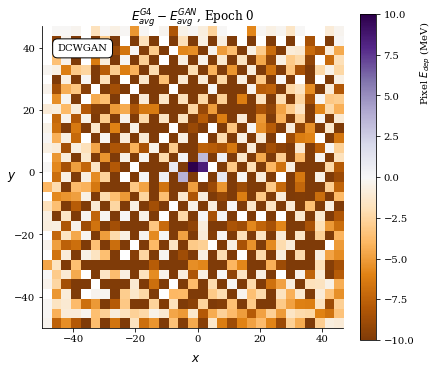

torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
[0/50][0/938] Loss_D: 0.1875 Loss_G: 1.5667 D(x): 1.1915
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([3

torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Si

Process Process-598:
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-597:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/home/chri

torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])
INTER:torch.Size([32, 1, 32, 32])
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/IPython/core/ultratb.py", line 376, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/IPython/utils/ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/enc

IndexError: string index out of range

In [119]:
iter_range = range(niter)
iter_range = tqdm(iter_range)


#make save directory
#mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCWGAN/', 
#                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
#print(mydir)
#try:
#    os.makedirs(mydir)
#except OSError as e:
 #   if e.errno != errno.EEXIST:
 #       raise

mydir = os.path.join('/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCWGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
import errno
#mydir=None
print(mydir)
if mydir != None:
    try:
        os.makedirs(mydir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            
    with open(mydir + 'NetworkInfo.txt', 'w') as f:
        f.write( 'generator: ' +  str(netG) + "\n")
        f.write('discriminator: ' +  str(netD) + '\n')
        f.write('normalization scale: ' +  norm_scale + '\n')
        f.write('image height/width: ' + str(imageSize) + '\n')
        f.write('loss function: WGAN-GP \n')
        f.write('epochs:' + str(niter) + '\n')
        f.write('batch size:' + str(batchSize) + '\n')

#mydir=None
        
extraD = 1
        
for epoch in iter_range:
    
    if True:
        data, n_events = make_samples(netG, n_events = 500)
        real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True, 
                                                                scale = scale, norm_scale = norm_scale)
        genx_FWHM = hist_width(np.sum(data[1],1))
        realx_FWHM = hist_width(np.sum(data[0],1))
        mean_energy_f.append(data[1].mean())
        mean_energy_r.append(data[0].mean())
        genx_mean = np.sum(data[1],1).mean()
        #print genx_mean
        realx_mean = np.sum(data[0],1).mean()
        genx_FWHMs.append(genx_FWHM)
        realx_FWHMs.append(realx_FWHM)
        genx_means.append(genx_mean)
        realx_means.append(realx_mean)
        epochs.append(epoch)
        plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, save_dir = mydir)
        plot_sns(n_events, save_dir=mydir)
        plot_avg_both(data[0],data[1], n_events, save_dir = mydir, epoch =epoch)
        plot_avg(data[1], n_events, save_dir= mydir, epoch = epoch)
        plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch)
        xsection_multi(data, epoch, savedir=mydir, imageSize=imageSize)
        if epoch % 1 == 0:
            plot_difference(data, save_dir = mydir, epoch = epoch, n_events = 5000)
        if epoch > 0:
            stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)
            plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 10)
        
    for i, data in enumerate(dataloader,0):
        for j in range(extraD):
            
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))), do it more than generator
            ###########################
            # train with real
            for p in netD.parameters():  # reset requires_grad
                p.requires_grad = True  # they are set to False below in netG update
                
            netD.zero_grad()
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
           # label = torch.full((batch_size,), real_label, device=device)

            output_Dr = netD(real_cpu)
            real_cpu.requires_grad_()
            #errD_real = criterion(output, label)
            D_x = output_Dr.mean()
            errD_real = D_x
            #errD_real.backward((torch.FloatTensor([1]) * -1).cuda(1))
            
            #D_x = output.mean()

            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            #label.fill_(fake_label)
            output_Df = netD(fake.detach())

            #errD_fake.backward()
            D_G_z1 = output_Df.mean()
            #errD = errD_real + errD_fake
            errD_fake = D_G_z1
            #errD_fake.backward((torch.FloatTensor([1])).cuda(1))

            errD = -errD_real + errD_fake
            #gradD = grad(errD, fake, create_graph=True, allow_unused=True)[0]
            
            #improved training of wasserstein gans
            #reguD = gradD.norm(2, 1).clamp(1).mean()

            lamD = 25.
            print(real_cpu.shape)
            gp = gradient_penalty(real_cpu, fake, lamda=lamD)
            (errD + gp).backward()
            #errD.backward()
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        for p in netD.parameters():
            p.requires_grad = False  # to avoid computation
        netG.zero_grad()
      #  label.fill_(real_label)  # fake labels are real for generator cost
        output_G = netD(fake)
        #errG = criterion(output, label)
        D_G_z2 = -1*output_G.mean() 
        #errG.backward((torch.FloatTensor([1]) * -1).cuda(1))
        errG = D_G_z2
        errG.backward(retain_graph=True)
        #D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x))
#         if i % 500 == 0:
#             vutils.save_image(real_cpu.data,
#                     '%s/real_samples.png' % outf,
#                     normalize=True)
#             fake = netG(fixed_noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
#                    normalize=True)

In [ ]:
#FAKE
#from mpl_toolkits.axes_grid1 import make_axes_locatable



test_unnormed, n_events = make_samples(netG,n_events = 500, real=False)
plot_avg(test_unnormed, n_events = 500, save_dir=None)

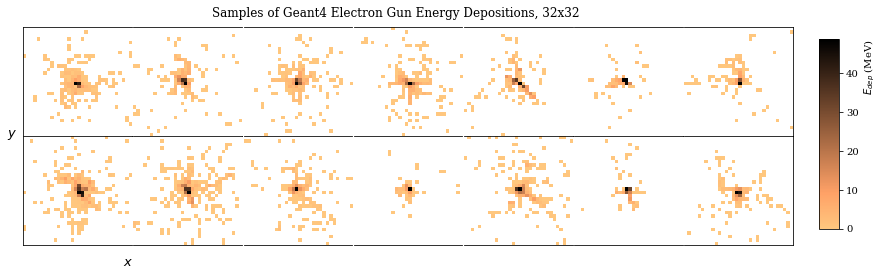

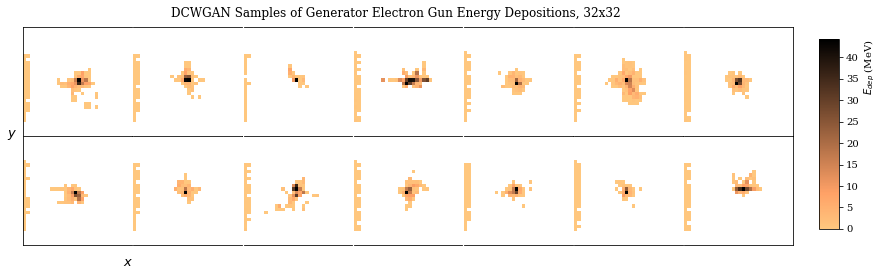

/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCWGAN/2018-08-27_05-48-22/


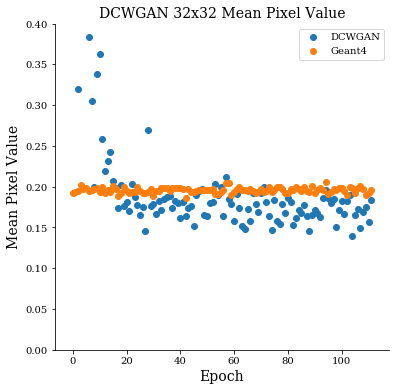

In [90]:
real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 1000,real= True, fake = True, 
                                                                scale = scale, norm_scale = norm_scale)
plot_many(real_data_array, rows=2, columns=7, real=True, save_dir=mydir, epoch=epoch)
plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch)

fig = plt.figure(figsize=(6,6))
plt.scatter(epochs, np.array(mean_energy_f) +0.02, label = 'DCWGAN')
plt.scatter(epochs, np.array(mean_energy_r), label = 'Geant4')
plt.ylim(0,0.4)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Mean Pixel Value', fontsize=14)
plt.title('DCWGAN 32x32 Mean Pixel Value', fontsize = 14)
sns.despine(left=False)
print(mydir)
plt.legend(loc='best')
plt.savefig(mydir + "MeanPixelValueApproachDCWGAN32.pdf")

In [34]:
def calc_means_stds(imageSize=imageSize, n_times= 50):
    means_r_lists = []
    stds_r_lists = []
    means_f_lists = []
    stds_f_lists = []
    for i in range(n_times):
        data_avg, n_events = make_samples(netG, n_events = 2500, norm_scale=norm_scale)
        if imageSize == 64:
            mini = -31.5
            maxi = 32.5
        elif imageSize == 32:
            mini = -15.5
            maxi = 16.5
        #bins = np.arange(-16,17,1)
        #bins = 0.5*(bins[1:] + bins[:-1])
        bins = np.tile(np.arange(mini,maxi,1),imageSize).reshape(imageSize,imageSize)
        #bins = np.tile(bins,imageSize).reshape(imageSize,imageSize)
        #mids = 0.5*(bins[:] + bins[:])
        #print(bins.shape)
        #print(data_set.shape, bins.shape, data_avg[0].shape)
        means_r = np.average(bins, weights=data_avg[0], axis = 1)
        stds_r = np.sqrt(np.average((bins - means_r)**2, weights=data_avg[0], axis=1))
        means_r_lists.append(means_r)
        stds_r_lists.append(stds_r)
        means_f = np.average(bins, weights=data_avg[1], axis = 1)
        stds_f = np.sqrt(np.average((bins - means_f)**2, weights=data_avg[1], axis=1))
        means_f_lists.append(means_f)
        stds_f_lists.append(stds_f)
    return [means_r_lists, stds_r_lists], [means_f_lists, stds_f_lists]

#stats_r, stats_f = calc_means_stds(imageSize=imageSize, n_times = 10)

def plot_means_stds(stats_r, stats_f, save_dir = mydir, trim = 10, imageSize =imageSize):
    slice_ixs = np.arange(0,imageSize,1)
    if len(stats_r[0]) < 2:
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        axes[0].scatter(slice_ixs, means_lists)
        axes[1].scatter(slice_ixs, stds_lists)
    else:
        means_r_lists = stats_r[0]
        stds_r_lists = stats_r[1]
        std_errs_r = np.array(stds_r_lists).std(0)
        mean_errs_r = np.array(means_r_lists).std(0)
        print(mean_errs_r.shape)
        means_r = np.array(means_r_lists).mean(0)
        stds_r = np.array(stds_r_lists).mean(0)
        means_f_lists = stats_f[0]
        stds_f_lists = stats_f[1]
        std_errs_f = np.array(stds_f_lists).std(0)
        mean_errs_f = np.array(means_f_lists).std(0)
        means_f = np.array(means_f_lists).mean(0)
        stds_f = np.array(stds_f_lists).mean(0)
        
        fig, axes = plt.subplots(1,2, figsize=(12,4.5))
        axes[0].plot(slice_ixs[trim:-trim], means_r[trim:-trim], 'o', label = 'Geant4')
        axes[1].plot(slice_ixs[trim:-trim], stds_r[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, means_r, yerr=mean_errs_r)
        #axes[1].errorbar(slice_ixs, stds_r, yerr=std_errs_r)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_r[trim:-trim]-mean_errs_r[trim:-trim], means_r[trim:-trim]+mean_errs_r[trim:-trim], alpha = 0.2)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_r[trim:-trim]-std_errs_r[trim:-trim], stds_r[trim:-trim]+std_errs_r[trim:-trim], alpha = 0.2)
        
        axes[0].plot(slice_ixs[trim:-trim], means_f[trim:-trim], 'o', label ='generator')
        axes[1].plot(slice_ixs[trim:-trim], stds_f[trim:-trim], 'o')
        #axes[0].errorbar(slice_ixs, np.array(means_lists).mean(0), yerr=mean_errs)
        #axes[1].errorbar(slice_ixs, np.array(stds_lists).mean(0), yerr=std_errs)
        axes[0].fill_between(slice_ixs[trim:-trim], 
                             means_f[trim:-trim]-mean_errs_f[trim:-trim], means_f[trim:-trim]+mean_errs_f[trim:-trim], alpha = 0.3)
        axes[1].fill_between(slice_ixs[trim:-trim], 
                             stds_f[trim:-trim]-std_errs_f[trim:-trim], stds_f[trim:-trim]+std_errs_f[trim:-trim], alpha = 0.3)
        axes[0].set_ylim(-3.5,3.5)
        if imageSize == 64:
            axes[1].set_ylim(-2,20.5)
        else:
            axes[1].set_ylim(-2,8.5)
        axes[0].legend(bbox_to_anchor=[2.6, 0.5], loc='center right', fontsize=12.5)
        axes[0].set_ylabel("Mean", fontsize = 13)
        axes[1].set_ylabel("Std Dev", fontsize = 13)
        axes[0].set_xlabel("Cross-Section Number")
        axes[1].set_xlabel("Cross-Section Number")
        #plt.subplots_adjust(wspace=0, hspace=0)
        fig.suptitle(r"DCWGAN Means and Standard Deviations of Each Cross-Section of Average Image, " + str(imageSize) +"x" + str(imageSize), fontsize=14)
        if save_dir != None:
            plt.savefig(save_dir + "MetricsCross-Section_Multi" + str(epoch) + ".pdf", bbox_inches='tight')
        plt.show()
    return
#plot_means_stds(stats_r, stats_f, trim = 11)

In [46]:
#REAL
plt.rc('font', family='serif')
many_samples = True
n_events = 5000
#make single samples for both real and fake. then make many samples and average if many_samples = True

#real
idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
real_image = image_array[idx][0]

#fake
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
fake_image = fake.to('cpu').detach().numpy()[0][0]
test_unnormed =  arctanh_unnormalize(fake_image, scale)

if many_samples == True:
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed +=  arctanh_unnormalize(fake_image, scale)

real_image = real_image / n_events
test_unnormed = test_unnormed / n_events
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=True)
xran = (-50,50)
yran = (-50,50)
extent = xran + yran





real_image[real_image < 0.0] = np.nan
cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
im = ax1.imshow(real_image, vmin = 0, extent=extent, origin='lower', cmap=cmap)




ax1.set_title("Real")
#cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        
test_unnormed[test_unnormed < 0.0] = np.nan
im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
ax2.set_title("Generator")

fig.tight_layout(rect=[0, 0, .9, 1])
cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
fig.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle(r" DCGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
             + str(imageSize) + "x" +str(imageSize) + " Image Size, " + str(niter) 
             + " Epochs, " + str(batchSize) + " Batch Size", x = 0.5, y = 0.9)
plt.show()

TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [412]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '/')
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/2018-05-16_17-09-05/


/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCWGAN/2018-08-27_04-41-27/


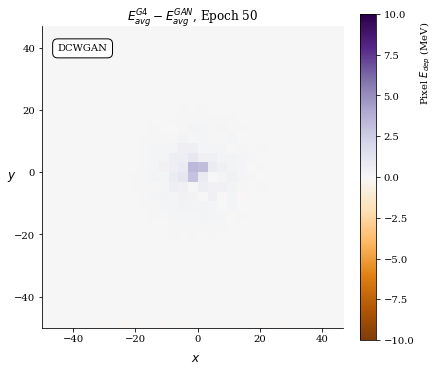

In [57]:
data_test, n_events = make_samples(netG,n_events = 10000, real=True, fake=True)
print(mydir)
plot_difference(data_test, save_dir = mydir, epoch = 50)

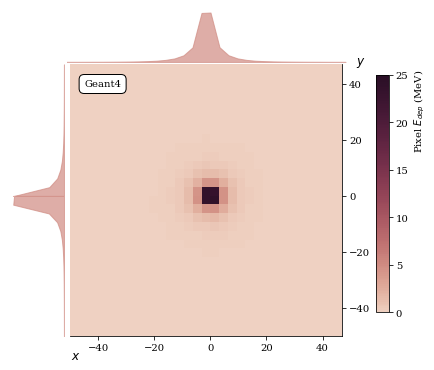

In [66]:
# mydir = "/home/chris/Dropbox/ForViewing/"
plot_avg(data_test[0], 5000, save_dir= mydir, epoch = epoch)

In [21]:
from scipy.stats import entropy
entro = 0
num = 2
for i in range(num):
    #p_nois = sample_noise(10000, n_latent)
    #outputs = netG(p_nois).cpu().data.numpy()
    #real_sample = sample_real(a=0.6, b=0.6,n_samples = 10000).cpu().data.numpy()
    data, n_events = make_samples(netG, n_events = 10000, scale =scale, norm_scale=norm_scale)
    real_sample_histo = data[0]
    outputs_histo = data[1]
    #outputs_histo, obins = np.histogram(outputs, bins = 20) 
    #real_sample_histo, sbins = np.histogram(real_sample, bins = 20)
    gen_probs = (np.ndarray.flatten(outputs_histo.astype(float)) / outputs_histo.sum()) + .00001
    real_probs = (np.ndarray.flatten(real_sample_histo.astype(float)) / real_sample_histo.sum()) + .00001
    #print(real_probs.sum())
    entro += entropy(gen_probs, real_probs)
    
entro = entro / num
print(entro)

0.05574034955763017
